# 01_Preprocessing

### Overview
This notebook focuses on data preprocessing for Crunch 1 of the Autoimmune Disease Machine Learning Challenge. The preprocessing step is critical to prepare the raw spatial transcriptomics data and H&E images for downstream modeling tasks. It ensures data quality, consistency, and compatibility with machine learning algorithms.

---

### Objectives
1. **Data Loading**: Load and validate raw data files (e.g., Zarr, H&E images, and gene expression tables).
2. **Image Preprocessing**:
   - Normalize H&E images.
   - Extract nucleus-centered patches for modeling.
3. **Gene Expression Preprocessing**:
   - Normalize and filter gene expression data.
   - Perform dimensionality reduction and clustering.
4. **Spatial Feature Engineering**:
   - Compute spatial features such as centroids, pairwise distances, and adjacency matrices.
5. **Save Outputs**: Store preprocessed data in the `interim` directory for use in downstream tasks.

---

### Expected Outputs
- **Processed H&E Images**:
  - Nucleus-centered patches with normalized intensities.
- **Processed Gene Expression**:
  - Normalized, filtered, and clustered gene expression data.
- **Spatial Features**:
  - Centroids, distances, and adjacency matrices for nuclei.

---

### Steps
1. **Imports and Configuration**: Load necessary libraries and initialize configurations.
2. **Data Loading**: Load raw data using the `DataLoader`.
3. **Preprocessing Tasks**:
   - Image Preprocessing (`ImagePreprocessor`).
   - Gene Expression Preprocessing (`GenePreprocessor`).
   - Spatial Preprocessing (`SpatialPreprocessor`).
4. **Save Outputs**: Ensure all preprocessed data is saved to the `interim` directory.
5. **Validation**: Validate preprocessed data visually or through summary statistics.


## Step 1. Imports and Configuration
This section initializes the preprocessing environment by:
- Importing core libraries and project-specific modules.
- Loading the configuration file (`config.yaml`) for path management.
- Setting up paths for raw and interim data.

In [1]:
# Import libraries
import os
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

/home/secondbook5/micromamba/envs/autoimmune_ml/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
# Import project-specific modules
from src.config.config_loader import ConfigLoader
from src.data_loader import DataLoader
from src.preprocessors.image_preprocessor import ImagePreprocessor
from src.preprocessors.gene_preprocessor import GenePreprocessor
from src.preprocessors.spatial_preprocessor import SpatialPreprocessor

In [3]:
# Load configuration and DataLoader for Crunch1
config_path = "/home/secondbook5/projects/AutoImmuneML/config.yaml"
config = ConfigLoader(config_path=config_path)
crunch_name = "crunch1"
# initialize data loader
data_loader = DataLoader(config=config, crunch_name="crunch1")


# Set paths
raw_dir = config.get_crunch_path(crunch_name, "raw_dir")
interim_dir = config.get_crunch_path(crunch_name, "interim_dir")

# Display paths
print(f"Raw directory: {raw_dir}")
print(f"Interim directory: {interim_dir}")

Raw directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data
Interim directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/interim


##  Step 2. Data Loading
This section loads the raw data from Zarr files using the `DataLoader`. The data includes:
1. **Images**: H&E registered images.
2. **Tables**: Gene expression data.

We also display a sample image and inspect the structure of the gene expression table to ensure correctness.


In [4]:
# Load all Zarr files in the raw directory
print(f"[INFO] Loading all Zarr files in directory: {raw_dir}")
all_zarr_data = data_loader.load_zarr([raw_dir])

# Display loaded datasets
print(f"[INFO] All loaded datasets: {list(all_zarr_data.keys())}")


[INFO] Loading all Zarr files in directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data


Loading Zarr files: 100%|██████████| 8/8 [01:43<00:00, 12.98s/it]

[INFO] All loaded datasets: ['DC1.zarr', 'UC1_NI.zarr', 'DC5.zarr', 'UC1_I.zarr', 'UC6_I.zarr', 'UC6_NI.zarr', 'UC7_I.zarr', 'UC9_I.zarr']


In [5]:
# Extract the specific dataset from the already loaded data
single_zarr_key = "UC1_NI.zarr"  # Specify the key of the dataset to process
if single_zarr_key in all_zarr_data:
    # Get the dataset directly from the loaded datasets
    sdata = all_zarr_data[single_zarr_key]
    print(f"[INFO] Using preloaded dataset: {single_zarr_key}")
else:
    raise KeyError(f"[ERROR] Dataset {single_zarr_key} not found in preloaded data.")

# Print the structure of the selected dataset
print(sdata)

[INFO] Using preloaded dataset: UC1_NI.zarr
SpatialData object, with associated Zarr store: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data/UC1_NI.zarr
├── Images
│     ├── 'DAPI': DataArray[cyx] (1, 51060, 53998)
│     ├── 'DAPI_nuc': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 21000, 22000)
│     ├── 'HE_nuc_registered': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_original': DataArray[cyx] (3, 21000, 22000)
│     ├── 'HE_registered': DataArray[cyx] (3, 51060, 53998)
│     ├── 'group': DataArray[cyx] (1, 51060, 53998)
│     └── 'group_HEspace': DataArray[cyx] (1, 21000, 22000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (2D points)
└── Tables
      ├── 'anucleus': AnnData (80037, 460)
      └── 'cell_id-group': AnnData (93686, 0)
with coordinate systems:
    ▸ 'global', with elements:
        DAPI (Images), DAPI_nuc (Images), HE_nuc_original (Images), HE_nuc_registered (Images), HE_original (Images), HE_registere

### 2.1 Visualizing the Input (X) and Output (Y)
This section focuses on enhancing the exploration of the loaded data:
1. **H&E Images (Input - X)**: These images provide spatial and morphological context for the tissue. We'll visualize both `HE_original` and `HE_nuc_original` to understand their differences and ensure the data is properly aligned.
2. **Gene Expression (Output - Y)**: This data represents the log1p-normalized gene expression profiles for each nucleus. We'll visualize subsets of this data and analyze the distribution of expression values.

#### Objectives
- Verify that the input and output data are correctly loaded.
- Gain insights into the structure and characteristics of the images and gene expression data.
- Identify any potential preprocessing requirements.


#### 2.1.1 Visualizing H&E Images (`X`)

H&E images provide the input features for our analysis. We will visualize:
 - `HE_original`: The raw H&E image.
- `HE_nuc_original`: The nucleus segmentation mask derived from the H&E image.
This helps confirm that the image layers are properly loaded and aligned.


Visualizing Image Pairs:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.034188036..1.0].


INFO     Rasterizing image for faster rendering.                                                                   


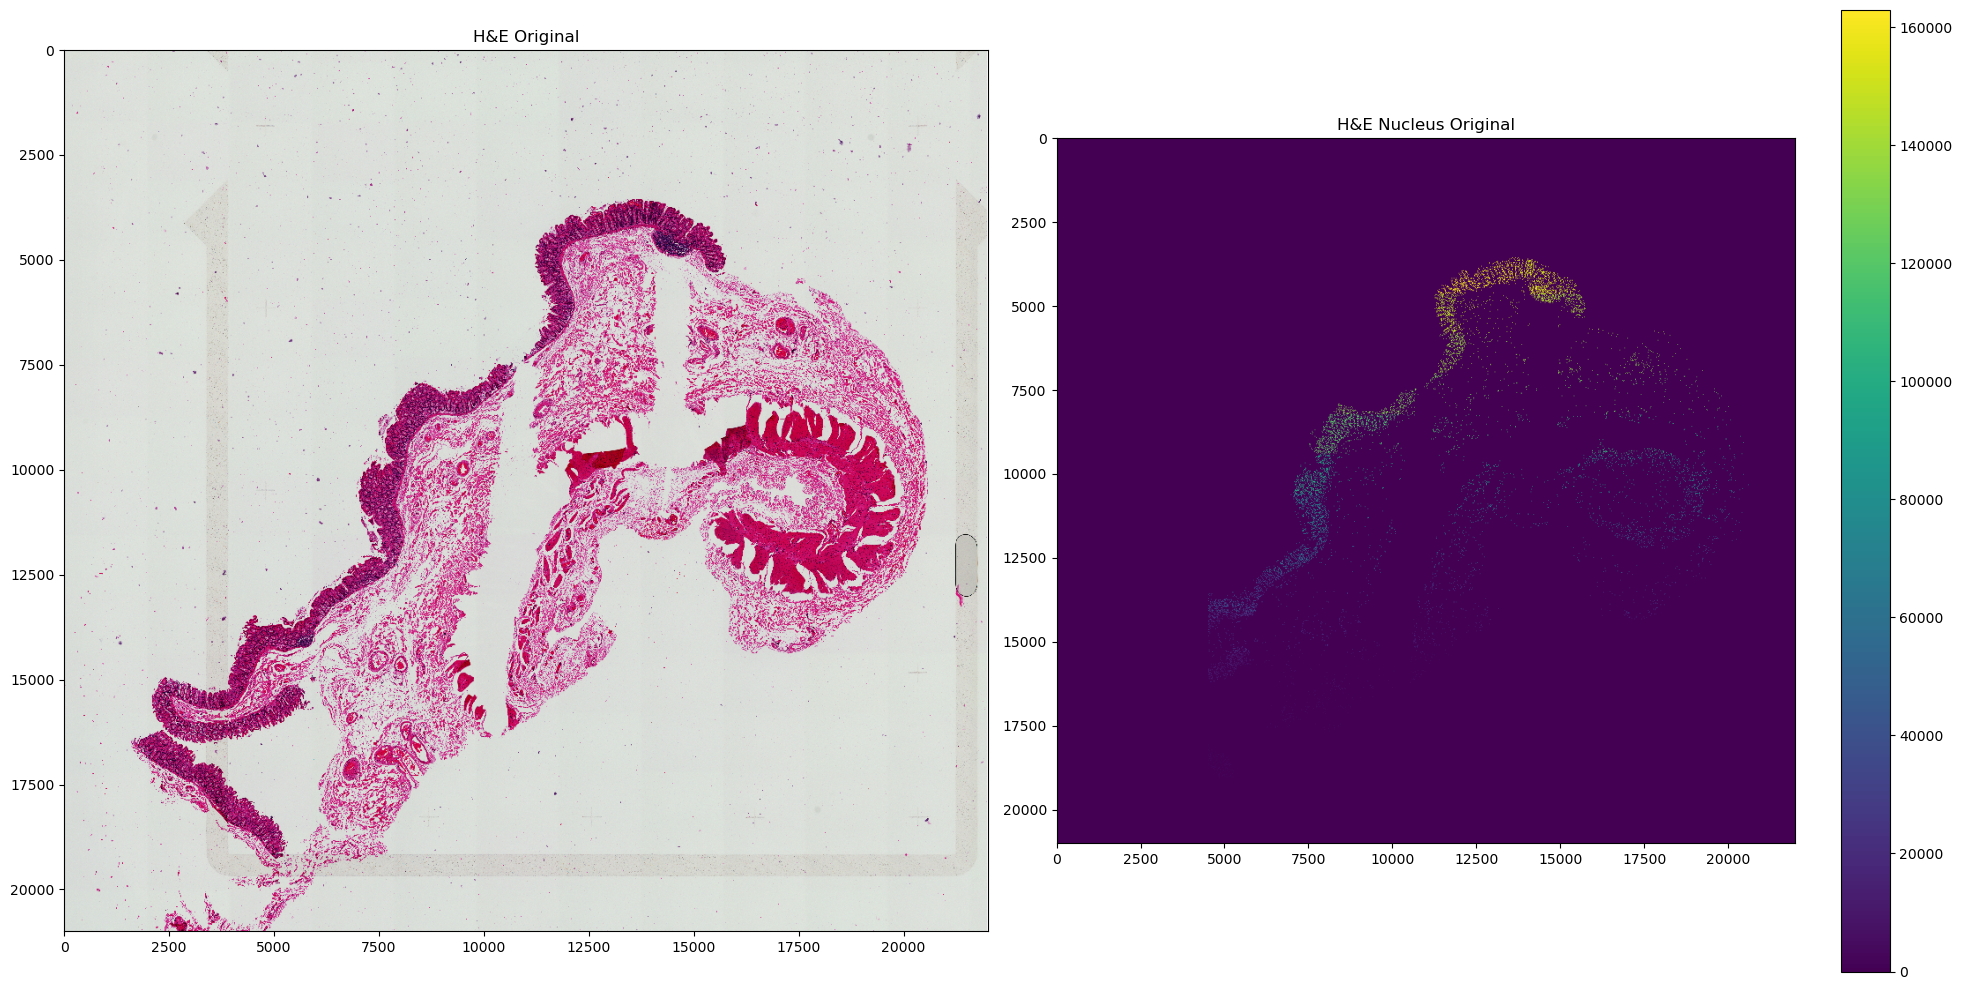

Visualizing Image Pairs: 100%|██████████| 1/1 [00:38<00:00, 38.61s/it]


In [6]:
def visualize_he_images(sdata, image_pairs=None, figsize=(20, 10), max_workers=4):
    """
    Visualize H&E images and their corresponding nucleus masks with progress tracking and parallel processing.

    Args:
        sdata (SpatialData): The spatial data object containing the images.
        image_pairs (list of tuples): List of (image_keys, titles) pairs to visualize.
            Defaults to visualizing H&E Original and Nucleus Original.
        figsize (tuple): Figure size for the plots.
        max_workers (int): Maximum number of threads for parallel processing.
    """
    # Default visualization pair if no custom pairs are provided
    default_pair = (["HE_original", "HE_nuc_original"], ["H&E Original", "H&E Nucleus Original"])
    image_pairs = image_pairs or [default_pair]  # Use the default pair if no pairs are specified

    # Define an inner function to process a single image pair
    def process_pair(image_keys, titles):
        # Ensure the number of image keys matches the number of titles
        if len(image_keys) != len(titles):
            raise ValueError("Each pair of image keys and titles must have the same length.")

        # Create a subplot layout for the current pair of images
        fig, axes = plt.subplots(1, len(image_keys), figsize=figsize)

        # Loop through each image key and its corresponding title
        for ax, key, title in zip(axes, image_keys, titles):
            # Check if the image key exists in the SpatialData object
            if key in sdata.images.keys():
                try:
                    # Render the image and display it in the corresponding subplot
                    sdata.pl.render_images(key).pl.show(ax=ax, title=title, coordinate_systems="global")
                except Exception as e:
                    # Handle any errors during rendering by displaying an error message
                    _display_error(ax, title, f"Error rendering: {str(e)}")
            else:
                # Display an error message if the image key is not found
                _display_error(ax, title, "Image not found")

        # Adjust the layout and show the plot for the current pair
        plt.tight_layout()
        plt.show()

    # Use ThreadPoolExecutor to process image pairs in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Execute the processing function for each pair using multiple threads
        list(tqdm(executor.map(lambda pair: process_pair(*pair), image_pairs),
                  desc="Visualizing Image Pairs", total=len(image_pairs)))

def _display_error(ax, title, error_message):
    """
    Display an error message in a subplot.

    Args:
        ax (matplotlib.axes.Axes): The axis for the subplot.
        title (str): Title of the image being visualized.
        error_message (str): Error message to display.
    """
    # Set the title of the subplot to indicate an error
    ax.set_title(f"{title}: Error")
    # Display the error message in the center of the subplot
    ax.text(0.5, 0.5, error_message, ha="center", va="center", fontsize=10, color="red")
    # Turn off the axis for clarity
    ax.axis("off")

# Extract the specific dataset from preloaded data
single_zarr_key = "UC1_NI.zarr"  # Specify the dataset key
single_dataset = all_zarr_data[single_zarr_key]  # Extract from preloaded data

# Define the image pairs and titles
image_pairs = [
    (["HE_original", "HE_nuc_original"], ["H&E Original", "H&E Nucleus Original"]),
]

# Visualize the images using the preloaded dataset
visualize_he_images(single_dataset, image_pairs=image_pairs)


[INFO] Image 'HE_nuc_original':
  - Shape: (1, 21000, 22000)
  - Mean Intensity: 850.95
  - Median Intensity: 0.00
  - Standard Deviation: 9992.67
  - Min Intensity: 0
  - Max Intensity: 162955


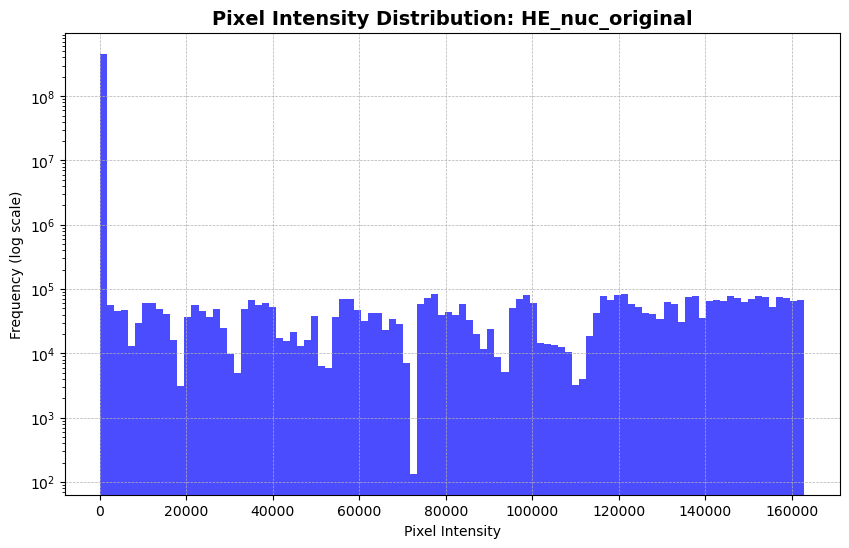

In [ ]:
def analyze_pixel_intensities(sdata, keys):
    """
    Analyze pixel intensities and display their distribution for images.

    Args:
        sdata (SpatialData): The spatial data object.
        keys (list): Keys of the images to analyze.
    """
    for key in keys:
        # Extract the image as a NumPy array
        image = sdata.images[key].to_numpy()

        # Calculate statistics
        mean_intensity = image.mean()
        median_intensity = np.median(image)
        std_dev = image.std()
        min_intensity = image.min()
        max_intensity = image.max()
        shape = image.shape

        # Log statistics
        print(f"[INFO] Image '{key}':")
        print(f"  - Shape: {shape}")
        print(f"  - Mean Intensity: {mean_intensity:.2f}")
        print(f"  - Median Intensity: {median_intensity:.2f}")
        print(f"  - Standard Deviation: {std_dev:.2f}")
        print(f"  - Min Intensity: {min_intensity}")
        print(f"  - Max Intensity: {max_intensity}")

        # Plot histogram of pixel intensities
        plt.figure(figsize=(10, 6))
        plt.hist(image.flatten(), bins=100, color="blue", alpha=0.7, log=True)
        plt.title(f"Pixel Intensity Distribution: {key}", fontsize=14, fontweight="bold")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency (log scale)")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.show()

# Example usage
analyze_pixel_intensities(
    single_dataset,
    keys=["HE_nuc_original", "HE_original"]
)


In [ ]:
def plot_nuclei_overlay(sdata, image_key, nuclei_key="HE_nuc_original", marker_color="yellow", marker_size=15):
    """
    Overlay nuclei centroids on the H&E image.

    Args:
        sdata (SpatialData): The spatial data object.
        image_key (str): Key of the H&E image.
        nuclei_key (str): Key of the nuclei image.
        marker_color (str): Color of the markers for nuclei centroids.
        marker_size (int): Size of the markers for nuclei centroids.
    """
    # Validate input keys
    if image_key not in sdata.images.keys():
        raise KeyError(f"Image key '{image_key}' not found in SpatialData images.")
    if nuclei_key not in sdata.images.keys():
        raise KeyError(f"Nuclei key '{nuclei_key}' not found in SpatialData images.")

    # Load images
    image = sdata.images[image_key].to_numpy()
    nuclei = sdata.images[nuclei_key].to_numpy()

    # Handle image dimensions
    if image.shape[0] == 1:  # Grayscale with singleton channel
        image = image.squeeze(0)
    elif image.shape[0] == 3:  # RGB with three channels
        image = np.transpose(image, (1, 2, 0))

    if nuclei.shape[0] == 1:  # Grayscale nuclei image
        nuclei = nuclei.squeeze(0)

    # Extract nuclei centroids
    regions = regionprops(nuclei)
    centroids = [r.centroid for r in regions]

    if not centroids:
        print("[INFO] No nuclei centroids found in the provided nuclei image.")
        return

    # Plot the H&E image with overlay
    plt.figure(figsize=(12, 12))
    plt.imshow(image, cmap="gray" if image.ndim == 2 else None)  # Grayscale if 2D, otherwise RGB
    plt.scatter(
        [c[1] for c in centroids], [c[0] for c in centroids],
        c=marker_color, s=marker_size, label="Nuclei Centroids"
    )
    plt.title(f"Overlay of Nuclei on {image_key}", fontsize=16, fontweight="bold")
    plt.legend()
    plt.axis("off")
    plt.show()

# Example usage:
plot_nuclei_overlay(single_dataset, image_key="HE_original", nuclei_key="HE_nuc_original")


In [ ]:
def analyze_nuclei_features(nuclei_image):
    """
    Analyze nuclei features such as area and eccentricity.

    Args:
        nuclei_image (np.ndarray): Binary nuclei image.

    Returns:
        None
    """
    # Label nuclei regions
    labeled_nuclei = label(nuclei_image)
    regions = regionprops(labeled_nuclei)

    areas = [r.area for r in regions]
    eccentricities = [r.eccentricity for r in regions]

    # Summary statistics
    print("\n[INFO] Nuclei Feature Analysis:")
    print(f" - Total Nuclei: {len(regions)}")
    print(f" - Mean Area: {np.mean(areas):.2f}")
    print(f" - Median Area: {np.median(areas):.2f}")
    print(f" - Mean Eccentricity: {np.mean(eccentricities):.2f}")
    print(f" - Median Eccentricity: {np.median(eccentricities):.2f}")

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(areas, bins=50, color="blue", alpha=0.7)
    plt.title("Nuclei Area Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("Area")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(eccentricities, bins=50, color="green", alpha=0.7)
    plt.title("Nuclei Eccentricity Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("Eccentricity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Example usage:
nuclei_image = single_dataset.images["HE_nuc_original"].to_numpy().squeeze(0)
analyze_nuclei_features(nuclei_image)


## 3. Preprocessing Tasks

### 3.1 H&E Image Preprocessing
- Normalize stains using Reinhard normalization.
- Extract nucleus-centered patches.
- Apply augmentations.


In [ ]:
# Initialize Image Preprocessor
image_preprocessor = ImagePreprocessor()

# Normalize and Extract Patches
for zarr_key, dataset in zarr_data.items():
    he_images = dataset["images"]["HE_registered"]
    he_nuc_masks = dataset["images"]["HE_nuc_registered"]

    # Example: Normalize
    normalized_images = image_preprocessor.normalize_stains(he_images)

    # Example: Patch Extraction
    patches = image_preprocessor.extract_patches(he_images, he_nuc_masks, patch_size=32)

    # Save to Interim Directory
    save_path = os.path.join(interim_dir, f"{zarr_key}_processed_images.npy")
    np.save(save_path, patches)


### 3.2 Gene Expression Preprocessing
- Normalize and filter gene expression data.
- Log-transform if needed.


In [ ]:
# Initialize Gene Preprocessor
gene_preprocessor = GenePreprocessor()

# Normalize Gene Expression
for zarr_key, dataset in zarr_data.items():
    anucleus_table = dataset["tables"]["anucleus"]
    normalized_genes = gene_preprocessor.normalize(anucleus_table)

    # Save to Interim Directory
    save_path = os.path.join(interim_dir, f"{zarr_key}_processed_genes.npy")
    np.save(save_path, normalized_genes)


### 3.3 Spatial Feature Engineering
- Compute distances between nuclei.
- Create adjacency matrices for spatial modeling.


In [ ]:
# Initialize Spatial Preprocessor
spatial_preprocessor = SpatialPreprocessor()

# Compute Features
for zarr_key, dataset in zarr_data.items():
    spatial_features = spatial_preprocessor.generate_features(dataset)

    # Save to Interim Directory
    save_path = os.path.join(interim_dir, f"{zarr_key}_spatial_features.npy")
    np.save(save_path, spatial_features)


## 4. Intermediate Validation
- Visualize preprocessed images, gene distributions, and spatial features.


In [ ]:
# Visualize Preprocessed Images
plt.imshow(patches[0])
plt.title("Example Preprocessed Patch")
plt.show()

# Plot Gene Expression Distribution
plt.hist(normalized_genes.flatten(), bins=50)
plt.title("Normalized Gene Expression Distribution")
plt.show()


## 5. Save Preprocessed Data
- Save all outputs to the `interim` directory.

In [ ]:
# Ensure Preprocessed Data is Stored Correctly
assert os.path.exists(interim_dir), "Interim directory does not exist!"

## 6. Notes and Next Steps
- Preprocessing is complete. The next step is Enhanced EDA.
- Key Observations:
  - ...
  - ...
